In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
data = pd.read_csv("./data/assessments/assessments_sales.csv")
print(data.head())

      tax_key  AssessmentYear  Assessment  NextYear  NextYearAssessment  \
0  2440132000            2009      113700      2010              108000   
1  2061316000            2009       78800      2010               74900   
2  2310306000            2009       97000      2010               92100   
3  1229979100            2009      131700      2010              131700   
4  2440969000            2009       93600      2010               89000   

     Sale convey_type  geo_alder  
0  105000          WD          1  
1   48400          QC          1  
2  100000          WD          1  
3  131500          WD          1  
4   79500          WD          1  


In [44]:
data['assessment_ratio'] = data.Assessment/data.Sale
data = data[((data['NextYearAssessment']/data['Assessment']) < 3)]
data = data[data['Assessment'] > 0]
data = data[data['assessment_ratio'] < 2]
data = data[data['assessment_ratio'] >= 0.5]
data = data[data['convey_type'].isin(["WD", "CD"])]
data = data[data['AssessmentYear'] >= 2012]

In [43]:
five = data[(data['geo_alder'] == 5.0)]
standard_five = five[five['convey_type'].isin(["WD", "CD"])]
fourteen = data[(data['geo_alder'] == 14.0)]
standard_fourteen = fourteen[fourteen['convey_type'].isin(["WD", "CD"])]
#print(standard_five.count()/five.count())
#print(standard_fourteen.count()/fourteen.count())

In [46]:
grouped = data.groupby('geo_alder')
data.sort_values(['assessment_ratio'], ascending=False).head(n=10)

,tax_key,AssessmentYear,Assessment,NextYear,NextYearAssessment,Sale,convey_type,geo_alder,assessment_ratio
11325,4350690000,2012,99200,2013,99200,50000,WD,8,1.984000
6665,3080501000,2014,110000,2015,110000,55600,WD,15,1.978417
9168,3210618000,2015,94500,2016,97500,48000,WD,3,1.968750
10895,1399986110,2014,115900,2015,115900,59000,WD,9,1.964407
7435,2251011000,2012,73600,2013,70000,37500,WD,2,1.962667
10125,2701043000,2012,40200,2013,38200,20500,WD,6,1.960976
78,2460129000,2012,49000,2013,49000,25000,WD,1,1.960000
5575,4970620000,2012,78200,2013,78200,40000,WD,14,1.955000
11422,2871513000,2013,63300,2014,68400,32500,WD,7,1.947692
10913,2850602000,2014,33000,2015,28800,17000,WD,7,1.941176


In [47]:
def coefficient_of_dispersion(assessment_ratios):
    median = np.median(assessment_ratios)
    return np.mean(np.abs(assessment_ratios - median))/median * 100

def price_related_differential(assessments, sales):
    assessment_ratios = assessments/sales
    return np.mean(assessment_ratios)/(np.sum(assessments)/np.sum(sales))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def permutation_sample(data_1, data_2):
    permuted_data = np.random.permutation(np.concatenate((data_1, data_2)))
    return permuted_data[:len(data_1)], permuted_data[len(data_1):]

def draw_perm_reps(d1, d2, func, size=1):
    return np.array([func(*permutation_sample(d1, d2)) for i in range(size)])

def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

In [48]:
median = np.median(data.assessment_ratio)
median

0.9330127020785219

In [49]:
# Coefficient of Disperson (COD)
cod = np.mean(np.abs(data.assessment_ratio - median))/median * 100
cod

14.948728750280951

In [50]:
# Price-Related Differential (PRD)
# PRD measures  measures a pattern of inequity in assessments that has a correlation with the value of the property.
# If there is a tendency for the higher-valued properties to exhibit lower assessment ratios than lower-values
# properties, the price-related differential will be greater than 1.03. If, on the other hand,
# higher-valued properties have higher assessment ratios than lower-valued properties,
# the price-related differential will be less than .98. Differentials greater than 1.03 or less than .98
# are both indicative of an inequity in assessment.
# City reported: 1.03
prd = np.mean(data.assessment_ratio)/(np.sum(data.Assessment)/np.sum(data.Sale))
prd

1.0415472474334366

In [51]:
#_ = plt.plot(data.sale, data.assessment_ratio, marker='.', linestyle='none')

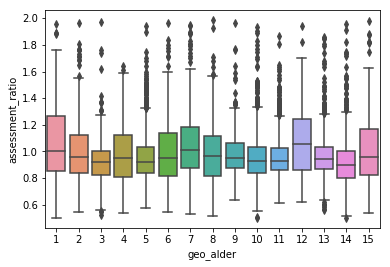

In [52]:
_ = sns.boxplot('geo_alder', 'assessment_ratio', data=data)

             count  median_assessment  median_assessment_ratio    prd
geo_alder                                                            
5         0   1681           115600.0                 0.920270  1.024
11        0   1583           126200.0                 0.931658  1.019
13        0   1217           128100.0                 0.943541  1.024
14        0   1070           137750.0                 0.896067  1.042
10        0    993           123100.0                 0.926330  1.040
2         0    525            75900.0                 0.955350  1.043
9         0    521           112800.0                 0.954783  1.021
3         0    499           240800.0                 0.917296  1.021
1         0    324            58850.0                 1.004449  1.068
7         0    300            71700.0                 1.010527  1.075
8         0    195            80200.0                 0.967273  1.055
6         0    155           101700.0                 0.952647  1.111
15        0    124  

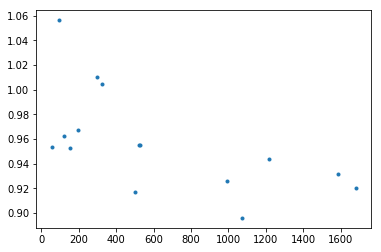

In [53]:

x = grouped.apply(lambda group: pd.DataFrame({
    'prd' : round(price_related_differential(group.Assessment, group.Sale), 3),
    'median_assessment_ratio' : [np.median(group.assessment_ratio)],
    'median_assessment' : [np.median(group.Assessment)],
    'count' : len(group)}))
print(x.sort_values(['count'], ascending=False))
_ = plt.plot(x['count'], x['median_assessment_ratio'], marker='.', linestyle='none')

In [60]:
def diff_of_medians(data_1, data_2):
    """Difference in medians of two arrays."""

    # The difference of medians of data_1, data_2: diff
    return np.median(data_1) - np.median(data_2)

fifth = data[(data['geo_alder'].isin([5]))].assessment_ratio.values
fourteenth = data[data['geo_alder'].isin([14])].assessment_ratio.values
empirical_diff_medians = diff_of_medians(fifth, fourteenth)
perm_replicates = draw_perm_reps(fifth, fourteenth,
                                 diff_of_medians, size=30000)
print(empirical_diff_medians)


# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_medians) / len(perm_replicates)

# Print the result
print('p-value =', p)

0.024203553060262673
p-value = 0.00036666666666666667


## Distribution of Assessment Ratios Across 5th and 14th districts

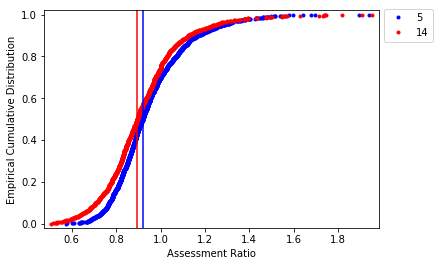

In [55]:
five_x, five_y = ecdf(fifth)
fourteen_x, fourteen_y = ecdf(fourteenth)

_ = plt.plot(five_x, five_y, marker='.', linestyle='none', color='blue', label='5')
_ = plt.plot(fourteen_x, fourteen_y, marker='.', linestyle='none', color='red', label='14')
plt.axvline(x=np.median(fifth), color='blue')
plt.axvline(x=np.median(fourteenth), color='red')
plt.xlabel('Assessment Ratio')
plt.ylabel('Empirical Cumulative Distribution')
plt.legend(bbox_to_anchor=(1,1.03))
plt.margins(0.02)
plt.show()

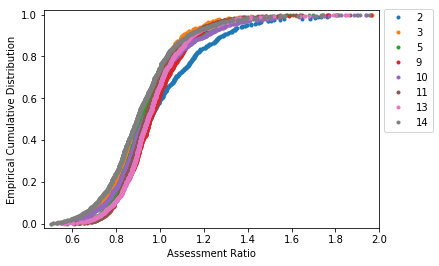

In [58]:
one_x, one_y = ecdf(data[data['geo_alder'] == 1].assessment_ratio.values)
two_x, two_y = ecdf(data[data['geo_alder'] == 2].assessment_ratio.values)
three_x, three_y = ecdf(data[data['geo_alder'] == 3].assessment_ratio.values)
four_x, four_y = ecdf(data[data['geo_alder'] == 4].assessment_ratio.values)
five_x, five_y = ecdf(data[data['geo_alder'] == 5].assessment_ratio.values)
six_x, six_y = ecdf(data[data['geo_alder'] == 6].assessment_ratio.values)
seven_x, seven_y = ecdf(data[data['geo_alder'] == 7].assessment_ratio.values)
eight_x, eight_y = ecdf(data[data['geo_alder'] == 8].assessment_ratio.values)
nine_x, nine_y = ecdf(data[data['geo_alder'] == 9].assessment_ratio.values)
ten_x, ten_y = ecdf(data[data['geo_alder'] == 10].assessment_ratio.values)
eleven_x, eleven_y = ecdf(data[data['geo_alder'] == 11].assessment_ratio.values)
twelve_x, twelve_y = ecdf(data[data['geo_alder'] == 12].assessment_ratio.values)
thirteen_x, thirteen_y = ecdf(data[data['geo_alder'] == 13].assessment_ratio.values)
fourteen_x, fourteen_y = ecdf(data[data['geo_alder'] == 14].assessment_ratio.values)
fifteen_x, fifteen_y = ecdf(data[data['geo_alder'] == 15].assessment_ratio.values)


#_ = plt.plot(one_x, one_y, marker='.', linestyle='none', label='1')
_ = plt.plot(two_x, two_y, marker='.', linestyle='none', label='2')
_ = plt.plot(three_x, three_y, marker='.', linestyle='none', label='3')
#_ = plt.plot(four_x, four_y, marker='.', linestyle='none', label='4')
_ = plt.plot(five_x, five_y, marker='.', linestyle='none', label='5')
#_ = plt.plot(six_x, six_y, marker='.', linestyle='none', label='6')
#_ = plt.plot(seven_x, seven_y, marker='.', linestyle='none', label='7')
#_ = plt.plot(eight_x, eight_y, marker='.', linestyle='none', label='8')
_ = plt.plot(nine_x, nine_y, marker='.', linestyle='none', label='9')
_ = plt.plot(ten_x, ten_y, marker='.', linestyle='none', label='10')
_ = plt.plot(eleven_x, eleven_y, marker='.', linestyle='none', label='11')
#_ = plt.plot(twelve_x, twelve_y, marker='.', linestyle='none', label='12')
_ = plt.plot(thirteen_x, thirteen_y, marker='.', linestyle='none', label='13')
_ = plt.plot(fourteen_x, fourteen_y, marker='.', linestyle='none', label='14')
#_ = plt.plot(fifteen_x, fifteen_y, marker='.', linestyle='none', label='15')
plt.xlabel('Assessment Ratio')
plt.ylabel('Empirical Cumulative Distribution')
plt.legend(bbox_to_anchor=(1,1.03))
plt.margins(0.02)
plt.show()